## Drainage Discharge Scaling

This is the unsaturated zone package example problem (test 2) from the
Unsaturated Zone Flow Package documentation (Niswonger and others, 2006).
All reaches have been converted to rectangular reaches.

### UZF Package Problem 2 Setup

### Initial setup

Import dependencies, define the example name and workspace, and read settings from environment variables.

In [1]:
import os
import pathlib as pl

import flopy
import git
import matplotlib.pyplot as plt
import numpy as np
import pooch
from flopy.plot.styles import styles
from modflow_devtools.latex import build_table, exp_format, float_format, int_format
from modflow_devtools.misc import get_env, timed

# Example name and workspace paths. If this example is running
# in the git repository, use the folder structure described in
# the README. Otherwise just use the current working directory.
sim_name = "ex-gwf-drn-p01"
try:
    root = pl.Path(git.Repo(".", search_parent_directories=True).working_dir)
except:
    root = None
workspace = root / "examples" if root else pl.Path.cwd()
figs_path = root / "figures" if root else pl.Path.cwd()
tbls_path = root / "tables" if root else pl.Path.cwd()
data_path = root / "data" / sim_name if root else pl.Path.cwd()

# Settings from environment variables
write = get_env("WRITE", True)
run = get_env("RUN", True)
plot = get_env("PLOT", True)
plot_show = get_env("PLOT_SHOW", True)
plot_save = get_env("PLOT_SAVE", True)

### Define parameters

Define model units, parameters and other settings.

In [2]:
# Model units
length_units = "feet"
time_units = "seconds"

# Scenario-specific parameters
parameters = {
    "ex-gwf-drn-p01a": {
        "uzf_gwseep": None,
    },
    "ex-gwf-drn-p01b": {
        "uzf_gwseep": True,
    },
}

# Model parameters
nper = 12  # Number of periods
nlay = 1  # Number of layers
nrow = 15  # Number of rows
ncol = 10  # Number of columns
delr = 5000.0  # Column width ($ft$)
delc = 5000.0  # Row width ($ft$)
strt = 1050.0  # Starting head ($ft$)
k11_stream = 0.002  # Hydraulic conductivity near the stream ($ft/s$)
k11_basin = 0.0004  # Hydraulic conductivity in the basin ($ft/s$)
ss = 1e-6  # Specific storage ($1/s)$
sy_stream = 0.2  # Specific yield near the stream (unitless)
sy_basin = 0.1  # Specific yield in the basin (unitless)
uzf_kv = 1e-6  # Vertical saturated hydraulic conductivity ($ft/s$)
thts = 0.3  # Saturated water content (unitless)
thti = 0.1  # Initial water content (unitless)
thtr = 0.1  # Base residual water content (unitless)
eps = 3.5  # Epsilon exponent (unitless)
evap_rate = 5.0e-8  # Evapotranspiration rate ($ft/s$)
extwc = 0.10005  # Evapotranspiration extinction wilting content (unitless)
ext_depth = 15.0  # Evapotranspiration extinction depth ($ft$)
surf_dep = 1.0  # Surface depression depth ($ft$)

# Static temporal data used by TDIS file
tdis_ds = [(2628000.0, 1, 1.0)]
for n in range(nper - 1):
    tdis_ds.append((2628000.0, 15, 1.1))

# Define dimensions
extents = (0.0, delr * ncol, 0.0, delc * nrow)
shape2d = (nrow, ncol)
shape3d = (nlay, nrow, ncol)

# Load the idomain, top, bottom, and uzf/mvr arrays
sfr_sim_name = "ex-gwf-sfr-p01"  # some data files come from another example
sfr_data_path = data_path.parent / sfr_sim_name if root else pl.Path.cwd()

fname = "idomain.txt"
fpath = pooch.retrieve(
    url=f"https://github.com/MODFLOW-USGS/modflow6-examples/raw/master/data/{sfr_sim_name}/{fname}",
    fname=fname,
    path=sfr_data_path,
    known_hash="md5:a0b12472b8624aecdc79e5c19c97040c",
)
idomain = np.loadtxt(fpath, dtype=int)

fname = "bottom.txt"
fpath = pooch.retrieve(
    url=f"https://github.com/MODFLOW-USGS/modflow6-examples/raw/master/data/{sfr_sim_name}/{fname}",
    fname=fname,
    path=sfr_data_path,
    known_hash="md5:fa5fe276f4f58a01eabfe88516cc90af",
)
botm = np.loadtxt(fpath, dtype=float)

fname = "top.txt"
fpath = pooch.retrieve(
    url=f"https://github.com/MODFLOW-USGS/modflow6-examples/raw/master/data/{sim_name}/{fname}",
    fname=fname,
    path=data_path,
    known_hash="md5:88cc15f87824ebfd35ed5b4be7f68387",
)
top = np.loadtxt(fpath, dtype=float)

fname = "infilt_mult.txt"
fpath = pooch.retrieve(
    url=f"https://github.com/MODFLOW-USGS/modflow6-examples/raw/master/data/{sim_name}/{fname}",
    fname=fname,
    path=data_path,
    known_hash="md5:8bf0a48d604263cb35151587a9d8ca29",
)
infilt_mult = np.loadtxt(fpath, dtype=float)

fname = "extwc_mult.txt"
fpath = pooch.retrieve(
    url=f"https://github.com/MODFLOW-USGS/modflow6-examples/raw/master/data/{sim_name}/{fname}",
    fname=fname,
    path=data_path,
    known_hash="md5:6e289692a2b55b7bafb8bd9d71b0a2cb",
)
extwc_mult = np.loadtxt(fpath, dtype=float)

fname = "routing_map.txt"
fpath = pooch.retrieve(
    url=f"https://github.com/MODFLOW-USGS/modflow6-examples/raw/master/data/{sim_name}/{fname}",
    fname=fname,
    path=data_path,
    known_hash="md5:1bf9a6bb3513a184aa5093485e622f5b",
)
routing_map = np.loadtxt(fpath, dtype=int)

# convert routing map to zero-based reach numbers
routing_map -= 1

# Create hydraulic conductivity and specific yield
k11 = np.zeros(shape2d, dtype=float)
k11[idomain == 1] = k11_stream
k11[idomain == 2] = k11_basin
sy = np.zeros(shape2d, dtype=float)
sy[idomain == 1] = sy_stream
sy[idomain == 2] = sy_basin

# Infiltration rates
infiltration = (
    1.0e-9,
    8.0e-9,
    1.0e-8,
    2.0e-8,
    5.0e-9,
    1.0e-8,
    3.0e-9,
    5.0e-9,
    3.0e-9,
    2.0e-9,
    1.0e-9,
    1.0e-9,
)

# Pumping rates
well_rates = (
    -2.0,
    -2.0,
    -1.0,
    -1.0,
    -3.0,
    0.0,
    -2.0,
    0.0,
    -1.0,
    0.0,
    -3.0,
    0.0,
)

# General head boundary conditions
ghb_spd = [
    [0, 12, 0, 988.0, 0.038],
    [0, 13, 8, 1045.0, 0.038],
]

# Well boundary conditions
wel_spd = {}
for n in range(nper):
    q = well_rates[n]
    if q == 0.0:
        wel_spd[n] = [[]]
    else:
        wel_spd[n] = [
            [0, 5, 3, q],
            [0, 5, 4, q],
            [0, 6, 3, q],
            [0, 6, 4, q],
            [0, 7, 3, q],
            [0, 7, 4, q],
            [0, 8, 3, q],
            [0, 8, 4, q],
            [0, 9, 3, q],
            [0, 9, 4, q],
        ]

# Drain boundary
drn_spd = []
for i in range(nrow):
    for j in range(ncol):
        if idomain[i, j] == 0:
            continue
        drncell = [0, i, j, top[i, j] - 0.5 * surf_dep, 25.0, 1.0, "surfrate"]
        drn_spd.append(drncell)

# UZF package
uzf_pakdata = []
iuzf = 0
for i in range(nrow):
    for j in range(ncol):
        if idomain[i, j] == 0:
            continue
        uzfcell = [
            iuzf,
            0,
            i,
            j,
            1,
            -1,
            surf_dep,
            uzf_kv,
            thtr * extwc_mult[i, j],
            thts,
            thti * extwc_mult[i, j],
            eps,
            "surfrate",
        ]
        uzf_pakdata.append(uzfcell)
        iuzf += 1

uzf_spd = {}
for n in range(nper):
    spd = []
    iuzf = 0
    for i in range(nrow):
        for j in range(ncol):
            if idomain[i, j] == 0:
                continue
            uzfcell = [
                iuzf,
                infiltration[n] * infilt_mult[i, j],
                evap_rate,
                ext_depth,
                extwc * extwc_mult[i, j],
                0,
                0,
                0,
            ]
            spd.append(uzfcell)
            iuzf += 1
    uzf_spd[n] = spd

# SFR Package
sfr_pakdata = [
    [0, 0, 0, 0, 4500.0, 12, 8.6767896e-04, 1093.048, 3.0, 0.00003, 0.030, 1, 1.0, 0],
    [1, 0, 1, 1, 7000.0, 12, 8.6767896e-04, 1088.059, 3.0, 0.00003, 0.030, 2, 1.0, 0],
    [2, 0, 2, 2, 6000.0, 12, 8.6767896e-04, 1082.419, 3.0, 0.00003, 0.030, 2, 1.0, 0],
    [3, 0, 2, 3, 5550.0, 12, 8.6767896e-04, 1077.408, 3.0, 0.00003, 0.030, 3, 1.0, 1],
    [4, 0, 3, 4, 6500.0, 12, 9.4339624e-04, 1071.934, 3.0, 0.00003, 0.030, 2, 1.0, 0],
    [5, 0, 4, 5, 5000.0, 12, 9.4339624e-04, 1066.509, 3.0, 0.00003, 0.030, 2, 1.0, 0],
    [6, 0, 5, 5, 5000.0, 12, 9.4339624e-04, 1061.792, 3.0, 0.00003, 0.030, 2, 1.0, 0],
    [7, 0, 6, 5, 5000.0, 12, 9.4339624e-04, 1057.075, 3.0, 0.00003, 0.030, 2, 1.0, 0],
    [8, 0, 7, 5, 5000.0, 12, 9.4339624e-04, 1052.359, 3.0, 0.00003, 0.030, 2, 1.0, 0],
    [9, 0, 2, 4, 5000.0, 10, 5.4545456e-04, 1073.636, 2.0, 0.00003, 0.030, 2, 0.0, 0],
    [10, 0, 2, 5, 5000.0, 10, 5.4545456e-04, 1070.909, 2.0, 0.00003, 0.030, 2, 1.0, 0],
    [11, 0, 2, 6, 4500.0, 10, 5.4545456e-04, 1068.318, 2.0, 0.00003, 0.030, 2, 1.0, 0],
    [12, 0, 3, 7, 6000.0, 10, 5.4545456e-04, 1065.455, 2.0, 0.00003, 0.030, 2, 1.0, 0],
    [13, 0, 4, 7, 5000.0, 10, 5.4545456e-04, 1062.455, 2.0, 0.00003, 0.030, 2, 1.0, 0],
    [14, 0, 5, 7, 2000.0, 10, 5.4545456e-04, 1060.545, 2.0, 0.00003, 0.030, 2, 1.0, 0],
    [15, 0, 4, 9, 2500.0, 10, 1.8181818e-03, 1077.727, 3.0, 0.00003, 0.030, 1, 1.0, 0],
    [16, 0, 4, 8, 5000.0, 10, 1.8181818e-03, 1070.909, 3.0, 0.00003, 0.030, 2, 1.0, 0],
    [17, 0, 5, 7, 3500.0, 10, 1.8181818e-03, 1063.182, 3.0, 0.00003, 0.030, 2, 1.0, 0],
    [18, 0, 5, 7, 4000.0, 15, 1.0000000e-03, 1058.000, 3.0, 0.00003, 0.030, 3, 1.0, 0],
    [19, 0, 6, 6, 5000.0, 15, 1.0000000e-03, 1053.500, 3.0, 0.00003, 0.030, 2, 1.0, 0],
    [20, 0, 7, 6, 3500.0, 15, 1.0000000e-03, 1049.250, 3.0, 0.00003, 0.030, 2, 1.0, 0],
    [21, 0, 7, 5, 2500.0, 15, 1.0000000e-03, 1046.250, 3.0, 0.00003, 0.030, 2, 1.0, 0],
    [22, 0, 8, 5, 5000.0, 12, 9.0909092e-04, 1042.727, 3.0, 0.00003, 0.030, 3, 1.0, 0],
    [23, 0, 9, 6, 5000.0, 12, 9.0909092e-04, 1038.182, 3.0, 0.00003, 0.030, 2, 1.0, 0],
    [24, 0, 10, 6, 5000.0, 12, 9.0909092e-04, 1033.636, 3.0, 0.00003, 0.030, 2, 1.0, 0],
    [25, 0, 11, 6, 5000.0, 12, 9.0909092e-04, 1029.091, 3.0, 0.00003, 0.030, 2, 1.0, 0],
    [26, 0, 12, 6, 2000.0, 12, 9.0909092e-04, 1025.909, 3.0, 0.00003, 0.030, 2, 1.0, 0],
    [27, 0, 13, 8, 5000.0, 55, 9.6774194e-04, 1037.581, 3.0, 0.00006, 0.025, 1, 1.0, 0],
    [28, 0, 12, 7, 5500.0, 55, 9.6774194e-04, 1032.500, 3.0, 0.00006, 0.025, 2, 1.0, 0],
    [29, 0, 12, 6, 5000.0, 55, 9.6774194e-04, 1027.419, 3.0, 0.00006, 0.025, 2, 1.0, 0],
    [30, 0, 12, 5, 5000.0, 40, 1.2500000e-03, 1021.875, 3.0, 0.00006, 0.025, 3, 1.0, 0],
    [31, 0, 12, 4, 5000.0, 40, 1.2500000e-03, 1015.625, 3.0, 0.00006, 0.025, 2, 1.0, 0],
    [32, 0, 12, 3, 5000.0, 40, 1.2500000e-03, 1009.375, 3.0, 0.00006, 0.025, 2, 1.0, 0],
    [33, 0, 12, 2, 5000.0, 40, 1.2500000e-03, 1003.125, 3.0, 0.00006, 0.025, 2, 1.0, 0],
    [34, 0, 12, 1, 5000.0, 40, 1.2500000e-03, 996.8750, 3.0, 0.00006, 0.025, 2, 1.0, 0],
    [35, 0, 12, 0, 3000.0, 40, 1.2500000e-03, 991.8750, 3.0, 0.00006, 0.025, 1, 1.0, 0],
]

sfr_conn = [
    [0, -1],
    [1, 0, -2],
    [2, 1, -3],
    [3, 2, -4, -9],
    [4, 3, -5],
    [5, 4, -6],
    [6, 5, -7],
    [7, 6, -8],
    [8, 7, -22],
    [9, 3, -10],
    [10, 9, -11],
    [11, 10, -12],
    [12, 11, -13],
    [13, 12, -14],
    [14, 13, -18],
    [15, -16],
    [16, 15, -17],
    [17, 16, -18],
    [18, 14, 17, -19],
    [19, 18, -20],
    [20, 19, -21],
    [21, 20, -22],
    [22, 8, 21, -23],
    [23, 22, -24],
    [24, 23, -25],
    [25, 24, -26],
    [26, 25, -30],
    [27, -28],
    [28, 27, -29],
    [29, 28, -30],
    [30, 26, 29, -31],
    [31, 30, -32],
    [32, 31, -33],
    [33, 32, -34],
    [34, 33, -35],
    [35, 34],
]

sfr_div = [[3, 0, 9, "UPTO"]]

sfr_spd = [
    [0, "inflow", 25.0],
    [15, "inflow", 10.0],
    [27, "inflow", 150.0],
    [3, "diversion", 0, 10.0],
    [9, "status", "simple"],
    [10, "status", "simple"],
    [11, "status", "simple"],
    [12, "status", "simple"],
    [13, "status", "simple"],
    [14, "status", "simple"],
    [9, "stage", 1075.545],
    [10, "stage", 1072.636],
    [11, "stage", 1069.873],
    [12, "stage", 1066.819],
    [13, "stage", 1063.619],
    [14, "stage", 1061.581],
]

# MVR package
mvr_paks = [
    ["SFR-1"],
    ["UZF-1"],
]

uzf_mvr_spd = []
iuzf = 0
for i in range(nrow):
    for j in range(ncol):
        if idomain[i, j] == 0:
            continue
        uzf_mvr_spd.append(["UZF-1", iuzf, "SFR-1", routing_map[i, j], "FACTOR", 1.0])
        iuzf += 1

drn_mvr_spd = []
idrn = 0
for i in range(nrow):
    for j in range(ncol):
        if idomain[i, j] == 0:
            continue
        drn_mvr_spd.append(["DRN-1", idrn, "SFR-1", routing_map[i, j], "FACTOR", 1.0])
        idrn += 1


# Solver parameters
nouter = 100
ninner = 50
hclose = 1e-6
rclose = 1e-6

### Model setup

Define functions to build models, write input files, and run the simulation.

In [3]:
def build_models(name, uzf_gwseep=None):
    sim_ws = os.path.join(workspace, name)
    sim = flopy.mf6.MFSimulation(sim_name=sim_name, sim_ws=sim_ws, exe_name="mf6")
    flopy.mf6.ModflowTdis(sim, nper=nper, perioddata=tdis_ds, time_units=time_units)
    flopy.mf6.ModflowIms(
        sim,
        print_option="summary",
        linear_acceleration="bicgstab",
        outer_maximum=nouter,
        outer_dvclose=hclose,
        inner_maximum=ninner,
        inner_dvclose=hclose,
        rcloserecord=f"{rclose} strict",
    )
    gwf = flopy.mf6.ModflowGwf(sim, modelname=sim_name, newtonoptions="newton")
    flopy.mf6.ModflowGwfdis(
        gwf,
        length_units=length_units,
        nlay=nlay,
        nrow=nrow,
        ncol=ncol,
        delr=delr,
        delc=delc,
        idomain=idomain,
        top=top,
        botm=botm,
    )
    flopy.mf6.ModflowGwfnpf(
        gwf,
        icelltype=1,
        k=k11,
    )
    flopy.mf6.ModflowGwfsto(
        gwf,
        iconvert=1,
        sy=sy,
        ss=ss,
        steady_state={0: True},
        transient={1: True},
    )
    flopy.mf6.ModflowGwfic(gwf, strt=strt)
    flopy.mf6.ModflowGwfghb(gwf, stress_period_data=ghb_spd)
    flopy.mf6.ModflowGwfwel(gwf, stress_period_data=wel_spd)
    sfr = flopy.mf6.ModflowGwfsfr(
        gwf,
        pname="SFR-1",
        length_conversion=3.28081,
        mover=True,
        nreaches=len(sfr_pakdata),
        packagedata=sfr_pakdata,
        connectiondata=sfr_conn,
        diversions=sfr_div,
        perioddata=sfr_spd,
    )
    uzf = flopy.mf6.ModflowGwfuzf(
        gwf,
        pname="UZF-1",
        simulate_gwseep=uzf_gwseep,
        simulate_et=True,
        linear_gwet=True,
        boundnames=True,
        mover=True,
        nuzfcells=len(uzf_pakdata),
        ntrailwaves=25,
        nwavesets=20,
        packagedata=uzf_pakdata,
        perioddata=uzf_spd,
    )

    mvr_packages = mvr_paks.copy()
    mvr_spd = uzf_mvr_spd.copy()
    obs_file = f"{sim_name}.surfrate.obs"
    csv_file = obs_file + ".csv"
    if uzf_gwseep:
        obs_dict = {
            csv_file: [
                ("surfrate", "uzf-gwd-to-mvr", "surfrate"),
                ("netinfil", "net-infiltration", "surfrate"),
            ]
        }
        uzf.obs.initialize(
            filename=obs_file,
            digits=10,
            print_input=True,
            continuous=obs_dict,
        )
    else:
        mvr_packages.append(["DRN-1"])
        mvr_spd += drn_mvr_spd.copy()
        drn = flopy.mf6.ModflowGwfdrn(
            gwf,
            pname="DRN-1",
            auxiliary=[("draindepth")],
            auxdepthname="draindepth",
            boundnames=True,
            mover=True,
            stress_period_data=drn_spd,
        )
        obs_dict = {
            csv_file: [
                ("surfrate", "to-mvr", "surfrate"),
            ]
        }
        drn.obs.initialize(
            filename=obs_file,
            digits=10,
            print_input=True,
            continuous=obs_dict,
        )

    flopy.mf6.ModflowGwfmvr(
        gwf,
        maxpackages=len(mvr_packages),
        maxmvr=len(mvr_spd),
        packages=mvr_packages,
        perioddata=mvr_spd,
    )

    flopy.mf6.ModflowGwfoc(gwf, printrecord=[("BUDGET", "LAST")])
    return sim


def write_models(sim, silent=True):
    sim.write_simulation(silent=silent)


@timed
def run_models(sim, silent=True):
    success, buff = sim.run_simulation(silent=silent)
    assert success, buff

### Plotting results

Define functions to plot model results.

In [4]:
# Figure properties
figure_size = (6.3, 5.6)
masked_values = (0, 1e30, -1e30)


def plot_stress_periods(ax):
    vmin, vmax = ax.get_ylim()
    x0 = 0.0
    x1 = 0.0
    for n in range(nper):
        if n % 2 == 0:
            color = "#3399FF"
        else:
            color = "#FFCC99"
        x1 += 30.42
        ax.fill_between(
            [x0, x1],
            vmin,
            y2=vmax,
            lw=0,
            color=color,
            step="post",
            alpha=0.25,
            ec="none",
        )
        x0 = x1


def plot_gwseep_results(silent=True):
    """Plot groundwater seepage results"""
    with styles.USGSPlot() as fs:
        # load the observations
        name = next(iter(parameters.keys()))
        fpth = os.path.join(workspace, name, f"{sim_name}.surfrate.obs.csv")
        drn = flopy.utils.Mf6Obs(fpth).data
        name = list(parameters.keys())[1]
        fpth = os.path.join(workspace, name, f"{sim_name}.surfrate.obs.csv")
        uzf = flopy.utils.Mf6Obs(fpth).data

        time = drn["totim"] / 86400.0
        q0 = drn["SURFRATE"]
        q1 = uzf["SURFRATE"]
        mean_error = np.mean(q0 - q1)

        # create the figure
        fig, axes = plt.subplots(
            ncols=2,
            nrows=1,
            sharex=True,
            figsize=(6.3, 3.15),
            constrained_layout=True,
        )

        ax = axes[0]
        ax.set_xlim(0, 365)
        ax.set_ylim(0, 175)

        xp, yp = [0.0], [uzf["NETINFIL"][0]]
        for idx in range(time.shape[0]):
            if idx == 0:
                x0, x1 = 0.0, time[idx]
            else:
                x0, x1 = time[idx - 1], time[idx]
            y2 = uzf["NETINFIL"][idx]
            xp.append(x0)
            xp.append(x1)
            yp.append(y2)
            yp.append(y2)
            ax.fill_between(
                [x0, x1],
                0,
                y2=y2,
                lw=0,
                color="blue",
                step="post",
                ec="none",
                zorder=100,
            )
        ax.plot(xp, yp, lw=0.5, color="black", zorder=101)
        plot_stress_periods(ax)
        styles.heading(ax, idx=0)

        ax.set_xlabel("Simulation time, in days")
        ax.set_ylabel("Infiltration to the unsaturated zone,\nin cubic feet per second")

        ax = axes[-1]
        ax.set_xlim(0, 365)
        ax.set_ylim(50.8, 51.8)
        ax.plot(
            time,
            -drn["SURFRATE"],
            lw=0.75,
            ls="-",
            color="blue",
            label="Drainage package",
        )
        ax.plot(
            time,
            -uzf["SURFRATE"],
            marker="o",
            ms=3,
            mfc="none",
            mec="black",
            markeredgewidth=0.5,
            lw=0.0,
            ls="-",
            color="red",
            label="UZF groundwater seepage",
        )
        plot_stress_periods(ax)

        styles.graph_legend(
            ax, loc="upper center", ncol=1, frameon=True, edgecolor="none"
        )
        styles.heading(ax, idx=1)
        styles.add_text(
            ax,
            f"Mean Error {mean_error:.2e} cubic feet per second",
            bold=False,
            italic=False,
            x=1.0,
            y=1.01,
            va="bottom",
            ha="right",
            fontsize=7,
        )

        ax.set_xlabel("Simulation time, in days")
        ax.set_ylabel(
            "Groundwater seepage to the land surface,\nin cubic feet per second"
        )

        if plot_show:
            plt.show()
        if plot_save:
            fpth = figs_path / f"{sim_name}-01.png"
            fig.savefig(fpth)


def export_tables(silent=True):
    if plot_save:
        caption = f"Infiltration and pumping rates for example {sim_name}."
        headings = (
            "Stress period",
            "Infiltration rate",
            "Pumping rate",
        )
        fpth = tbls_path / f"{sim_name}-02.tex"
        dtype = [
            ("nper", "U30"),
            ("infilt", "U30"),
            ("rate", "U30"),
        ]
        arr = np.zeros(nper, dtype=dtype)
        for n in range(nper):
            arr["nper"][n] = int_format(n + 1)
            arr["infilt"][n] = exp_format(infiltration[n])
            arr["rate"][n] = float_format(well_rates[n])
        if not silent:
            print(f"creating...'{fpth}'")
        col_widths = (0.1, 0.30, 0.30)
        build_table(caption, fpth, arr, headings=headings, col_widths=col_widths)


def plot_results(silent=True):
    if not plot:
        return
    plot_gwseep_results(silent=silent)
    export_tables(silent=silent)

### Running the example

Define and invoke a function to run the example scenario, then plot results.

In [5]:
def scenario(idx, silent=True):
    key = list(parameters.keys())[idx]
    params = parameters[key].copy()
    sim = build_models(key, **params)
    if write:
        write_models(sim, silent=silent)
    if run:
        run_models(sim, silent=silent)

Use the drain approach to simulate discharge to the land surface.

In [6]:
scenario(0)

run_models took 1595.44 ms


Use UZF to simulate discharge to the land surface.

In [7]:
scenario(1)

run_models took 2222.40 ms


Plot the results.

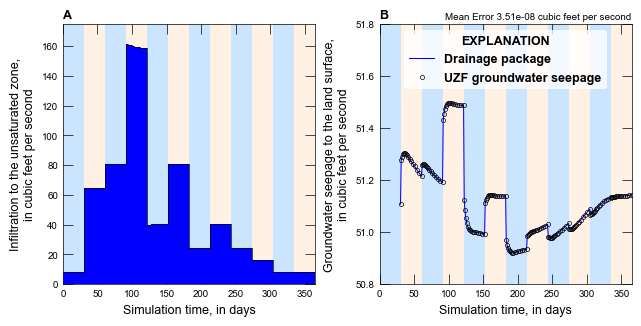

In [8]:
if plot:
    plot_results()